In [98]:

from casadi import *
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
from tensorflow_casadi import TensorFlowEvaluator
tf.keras.backend.set_floatx('float64')

class Neural_Network(TensorFlowEvaluator):
    def __init__(self, name, model,session,opts={}):
        self.model = model
        X = tf.placeholder(shape=(1,10),dtype=np.float64)
        mean = model(X)
        #mean = tf.reshape(mean,(5,1))
        print(mean)
        TensorFlowEvaluator.__init__(self,[X],[mean],session,opts)
        self.counter = 0
        self.time = 0

    # Number of inputs and outputs
    def get_n_in(self): return 1

    def get_n_out(self): return 1

    def get_sparsity_in(self, i):
        return Sparsity.dense(1, 10)

    def get_sparsity_out(self, i):
        return Sparsity.dense(1, 5)

    # Evaluate numerically
    def eval(self, arg):
        model = self.model
        s = np.array(arg[0])
        s = s.astype('float64')
        f = model.predict(s)
        return [f[0]]



In [ ]:

def MPC(s, model, xref=[1, 0, 0]):
    opti = casadi.Opti()

    nn = Neural_Network('netwerk', model, opts={"enable_fd": True})

    state = MX.sym('state', 3)
    action = MX.sym('action')
    input = vertcat(state, action)
    f = Function('f', [state, action], [nn(input)])

    #time horizon
    N = 100

    x = opti.variable(3, N + 1)
    u = opti.variable(1, N)

    x_ref = opti.parameter(3, N + 1)
    p = opti.parameter(3, 1)

    ref = np.zeros((3, N + 1))
    for i in range(N + 1):
        ref[0, i] = xref[0]
        ref[1, i] = xref[1]
        ref[2, i] = xref[2]

    Q = MX.eye(3)  # needs to be optimised
    Q[0, 0] = 100
    Q[1, 1] = 5
    R = MX.zeros(1, 1)  # MX.eye(1)

    def cost(x, u, x_ref):
        s = 0
        for n in range(N):
            s += mtimes(mtimes((x[:, n] - x_ref[:, n]).T, Q), (x[:, n] - x_ref[:, n]))
            s += mtimes(mtimes(u[:, n].T, R), u[:, n])
        s += mtimes(mtimes((x[:, N] - x_ref[:, N]).T, Q), (x[:, N] - x_ref[:, N]))
        return s

    opti.minimize(cost(x, u, x_ref))

    for k in range(N):
        opti.subject_to(x[:, k + 1] == f(x[:, k], u[:, k]))

    opti.subject_to(x[:, 0] == p)
    opti.subject_to(u <= 2)
    opti.subject_to(u >= -2)
    opti.solver('sqpmethod', {'qpsol': 'qrqp'})

    opti.set_value(p, s)
    opti.set_value(x_ref, ref)

    sol = opti.solve()
    return sol.value(u)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 64)                704       
                                                                 
 dense_70 (Dense)            (None, 64)                4160      
                                                                 
 dense_71 (Dense)            (None, 5)                 325       
                                                                 
Total params: 5,189
Trainable params: 5,189
Non-trainable params: 0
_________________________________________________________________
None
float64


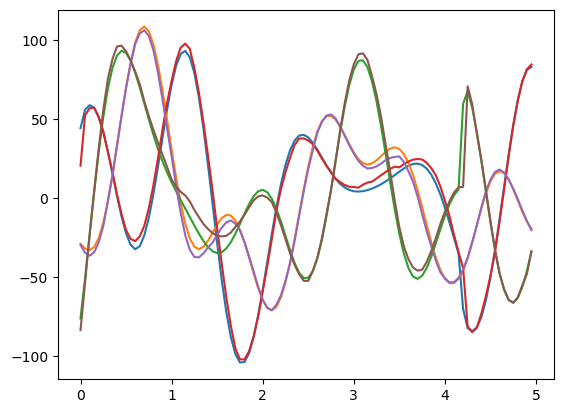

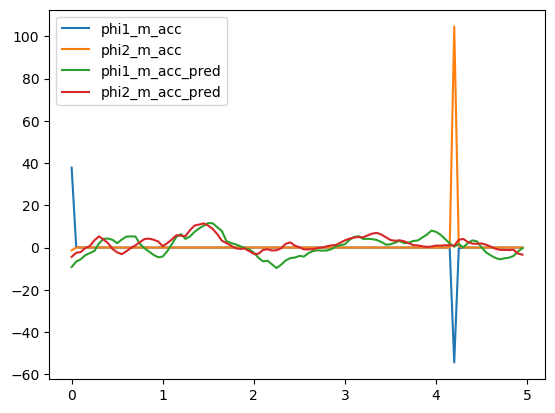

In [99]:
import matplotlib.pyplot as plt
model=tf.keras.models.load_model('output/disk.h5')
print(model.summary())
data_valid = np.loadtxt('foo_valid.csv',delimiter=',')

dt=0.05
acc_pred = model.predict(data_valid[0:100,:])

print(acc_pred.dtype)

t = np.linspace(0,dt*99,99+1)
plt.figure(1)
acc = (data_valid[1:101,:] - data_valid[0:100,:])/dt
plt.plot(t,acc[:,3],label='phi1_acc')
plt.plot(t,acc[:,4],label='phi2_acc')
plt.plot(t,acc[:,5],label='phi3_acc')

plt.plot(t,acc_pred[:,0],label='phi1_acc_pred')
plt.plot(t,acc_pred[:,1],label='phi2_acc_pred')
plt.plot(t,acc_pred[:,2],label='phi3_acc_pred')

plt.figure(2)
plt.plot(t,acc[:,6],label='phi1_m_acc')
plt.plot(t,acc[:,7],label='phi2_m_acc')


plt.plot(t,acc_pred[:,3],label='phi1_m_acc_pred')
plt.plot(t,acc_pred[:,4],label='phi2_m_acc_pred')


plt.legend()
plt.show()

In [100]:


with tf.Session() as session:
    nn = Neural_Network('netwerk', model, session,opts={"enable_fd": True})

    state = MX.sym('state', 8)
    control = MX.sym('action',2)
    input = vertcat(state, control)
    f = Function('f', [state, control], [nn(input).T])

    N = 50
    nx = 8
    nu = 2
    dt = 0.05
    x0 = np.pi*np.array([1, 1, -1.5, 1, -1, 1, 0, 0]).reshape(-1,1)

    option = {}
    option['max_iter']=10000

    #option['print_level']=0

    opti = casadi.Opti()
    x = opti.variable(8,N+1)
    u = opti.variable(2,N+1)

    phi_1= x[0,:]
    phi_2= x[1,:]
    phi_3= x[2,:]
    dphi_1= x[3,:]
    dphi_2= x[4,:]
    dphi_3= x[5,:]
    phi_1_m= x[6,:]
    phi_2_m= x[7,:]

    phi_m_1_set = u[0,:]
    phi_m_2_set = u[1,:]

    for k in range(N):
        opti.subject_to(x[0:3, k + 1] == x[0:3, k] + dt * x[3:6, k])
        opti.subject_to(x[3:8, k + 1] == x[3:8, k] + dt * f(x[:, k].T, u[:, k].T))


    opti.minimize(casadi.dot(phi_1,phi_1)+casadi.dot(phi_2,phi_2)+casadi.dot(phi_3,phi_3)
                  +0.001*casadi.dot(phi_m_1_set,phi_m_1_set)+0.1*casadi.dot(phi_m_2_set,phi_m_2_set)
                  +0.001*casadi.dot(phi_1_m,phi_1_m)+0.1*casadi.dot(phi_2_m,phi_2_m))


    opti.subject_to(x[:,0]==x0)

    opti.subject_to(opti.bounded(-2*casadi.pi,phi_1,2*casadi.pi))
    opti.subject_to(opti.bounded(-2*casadi.pi,phi_2,2*casadi.pi))
    opti.subject_to(opti.bounded(-2*casadi.pi,phi_3,2*casadi.pi))

    opti.subject_to(opti.bounded(-2*casadi.pi,phi_1_m,2*casadi.pi))
    opti.subject_to(opti.bounded(-2*casadi.pi,phi_1_m,2*casadi.pi))


    opti.subject_to(opti.bounded(-2*casadi.pi,phi_m_1_set,2*casadi.pi))
    opti.subject_to(opti.bounded(-2*casadi.pi,phi_m_2_set,2*casadi.pi))



    opti.solver("ipopt",{},option)

    try:
        sol = opti.solve()

    except Exception as e:
        print(e)

2022-10-11 14:16:18.158432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 14:16:18.158646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 14:16:18.158760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 14:16:18.158935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 14:16:18.159055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Tensor("sequential_5/dense_71/BiasAdd:0", shape=(1, 5), dtype=float64)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3208
Number of nonzeros in inequality constraint Jacobian.:      357
Number of nonzeros in Lagrangian Hessian.............:     2757



FailedPreconditionError: 2 root error(s) found.
  (0) FAILED_PRECONDITION: Could not find variable dense_70/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/dense_70/kernel)
	 [[{{node dense_70/MatMul/ReadVariableOp}}]]
	 [[dense_71/BiasAdd/_3]]
  (1) FAILED_PRECONDITION: Could not find variable dense_70/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/dense_70/kernel)
	 [[{{node dense_70/MatMul/ReadVariableOp}}]]
0 successful operations.
0 derived errors ignored.

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!


CasADi - 2022-10-11 14:16:18 WARNING("solver:nlp_jac_g failed:Error in Function::operator() for 'nlp_jac_g' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'TensorFlowEvaluator' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for TensorFlowEvaluator:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object TensorFlowEvaluator:
.../casadi/build/swig/casadiPYTHON_wrap.cxx:3799: 2 root error(s) found.
  (0) FAILED_PRECONDITION: Could not find variable dense_70/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/dense_70/kernel)
	 [[{{node dense_70/MatMul/ReadVariableOp}}]]
	 [[den

FailedPreconditionError: 2 root error(s) found.
  (0) FAILED_PRECONDITION: Could not find variable dense_70/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/dense_70/kernel)
	 [[{{node dense_70/MatMul/ReadVariableOp}}]]
	 [[dense_71/BiasAdd/_3]]
  (1) FAILED_PRECONDITION: Could not find variable dense_70/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/dense_70/kernel)
	 [[{{node dense_70/MatMul/ReadVariableOp}}]]
0 successful operations.
0 derived errors ignored.

Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!


CasADi - 2022-10-11 14:16:18 WARNING("solver:nlp_jac_g failed:Error in Function::operator() for 'nlp_jac_g' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'TensorFlowEvaluator' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for TensorFlowEvaluator:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object TensorFlowEvaluator:
.../casadi/build/swig/casadiPYTHON_wrap.cxx:3799: 2 root error(s) found.
  (0) FAILED_PRECONDITION: Could not find variable dense_70/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/dense_70/kernel)
	 [[{{node dense_70/MatMul/ReadVariableOp}}]]
	 [[den

FailedPreconditionError: 2 root error(s) found.
  (0) FAILED_PRECONDITION: Could not find variable dense_70/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/dense_70/kernel)
	 [[{{node dense_70/MatMul/ReadVariableOp}}]]
	 [[dense_71/BiasAdd/_3]]
  (1) FAILED_PRECONDITION: Could not find variable dense_70/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/dense_70/kernel)
	 [[{{node dense_70/MatMul/ReadVariableOp}}]]
0 successful operations.
0 derived errors ignored.


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total CPU secs in IPOPT (w/o function evaluations)   =      0.432
Total CPU secs in NLP function evaluations           =      0.052

EXIT: Invalid number in NLP function or derivative detected.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  51.81ms ( 51.81ms)  50.71ms ( 50.71ms)         1
  nlp_grad_f  |  11.00us ( 11.00us)  10.15us ( 10.15us)         1
   nlp_jac_g  | 434.52ms (217.26ms) 432.84ms (216.42ms)         2
       total  | 486.92ms (486.92ms) 483.99ms (483.99ms)         1
Error in Opti::solve [OptiNode] at .../casadi/c

CasADi - 2022-10-11 14:16:18 WARNING("solver:nlp_g failed:Error in Function::operator() for 'nlp_g' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'TensorFlowEvaluator' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for TensorFlowEvaluator:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object TensorFlowEvaluator:
.../casadi/build/swig/casadiPYTHON_wrap.cxx:3799: 2 root error(s) found.
  (0) FAILED_PRECONDITION: Could not find variable dense_70/kernel. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/dense_70/kernel)
	 [[{{node dense_70/MatMul/ReadVariableOp}}]]
	 [[dense_71/Bi